# Topik: Natural Language Processing (Klasifikasi Teks)

**Dataset:** 12.000 ulasan film dari **IMDB Reviews**, terbagi dalam 2 kelas (positif/negatif).
* 10000 Train data
* 2000 Test data
---

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import re
import string
import numpy as np
from tensorflow.keras import layers, models, optimizers

In [ ]:
(raw_train, raw_test), metadata = tfds.load(
    'imdb_reviews',
    split=['train[:10000]', 'test[:2000]'],
    with_info=True,
    as_supervised=True,
)

print("Beberapa contoh ulasan dan labelnya:")
for text, label in raw_train.take(3):
    print(f"Label: {'Positif' if label.numpy() == 1 else 'Negatif'}")
    print(f"Ulasan: {text.numpy().decode('utf-8')[:100]}...\n")

BATCH_SIZE = 32
BUFFER_SIZE = 1000

train_dataset = raw_train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = raw_test.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("Training batches:", len(train_dataset))
print("Testing batches:", len(test_dataset))

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.V824BH_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.V824BH_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.V824BH_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
Beberapa contoh ulasan dan labelnya:
Label: Negatif
Ulasan: This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. ...

Label: Negatif
Ulasan: I have been known to fall asleep during films, but this is usually due to a combination of things in...

Label: Negatif
Ulasan: Mann photographs the Alberta Rocky Mountains in a superb fashion, and Jimmy Stewart and Walter Brenn...

Training batches: 313
Testing batches: 63


Jumlah data train  : 10000
Positif            : 5002
Negatif            : 4998
Panjang rata-rata review (kata) : 233.1


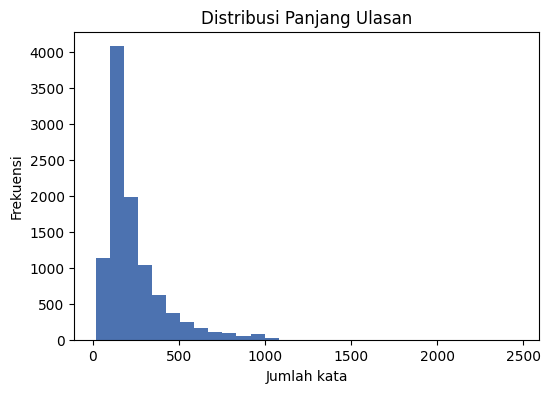

In [ ]:
review_lengths = []
labels = []

for text_tensor, label_tensor in raw_train:
    labels.append(label_tensor.numpy())
    review_lengths.append(
        len(text_tensor.numpy().decode("utf-8").split())
    )

pos_count = int(np.sum(labels))
neg_count = len(labels) - pos_count

print(f"Jumlah data train  : {len(labels)}")
print(f"Positif            : {pos_count}")
print(f"Negatif            : {neg_count}")
print(f"Panjang rata-rata review (kata) : {np.mean(review_lengths):.1f}")

plt.figure(figsize=(6, 4))
plt.hist(review_lengths, bins=30, color="#4c72b0")
plt.title("Distribusi Panjang Ulasan")
plt.xlabel("Jumlah kata")
plt.ylabel("Frekuensi")
plt.show()

In [ ]:
VOCAB_SIZE = 10_000
SEQ_LEN = 200

vectorize_layer = layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LEN,
)

text_only_ds = raw_train.map(lambda txt, lbl: txt)
vectorize_layer.adapt(text_only_ds.batch(BATCH_SIZE))

def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

train_ds = train_dataset.map(vectorize_text)
test_ds = test_dataset.map(vectorize_text)

# Bagi sebagian train menjadi validation
train_batches = len(train_ds)
val_batches = int(0.2 * train_batches)

val_ds = train_ds.take(val_batches)
train_ds_final = train_ds.skip(val_batches)

In [ ]:
embedding_dim = 16
lstm_units    = 32

def create_baseline_model():
    inputs = layers.Input(shape=(SEQ_LEN,), dtype="int64")

    x = layers.Embedding(VOCAB_SIZE, embedding_dim)(inputs)
    x = layers.LSTM(lstm_units)(x)
    x = layers.Dense(16, activation="relu")(x)

    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = models.Model(inputs, outputs, name="baseline_lstm")

    return model

baseline_model = create_baseline_model()
baseline_model.compile(
    loss="binary_crossentropy",
    optimizer=optimizers.Adam(0.0001),
    metrics=["accuracy"],
)

baseline_model.summary()

Model: "baseline_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 200, 16)        │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 166,817 (651.63 KB)

 Trainable params: 166,817 (651.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = baseline_model.fit(
    train_ds_final,
    validation_data=val_ds,
    epochs=10,
    verbose=1,
)

Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 25s 88ms/step - accuracy: 0.4865 - loss: 0.6932 - val_accuracy: 0.5101 - val_loss: 0.6930
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 22s 88ms/step - accuracy: 0.5057 - loss: 0.6929 - val_accuracy: 0.5207 - val_loss: 0.6928
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 21s 82ms/step - accuracy: 0.5020 - loss: 0.6925 - val_accuracy: 0.5227 - val_loss: 0.6918
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 22s 88ms/step - accuracy: 0.5067 - loss: 0.6908 - val_accuracy: 0.5272 - val_loss: 0.6916
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 22s 88ms/step - accuracy: 0.5527 - loss: 0.6881 - val_accuracy: 0.5842 - val_loss: 0.6586
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 22s 87ms/step - accuracy: 0.6614 - loss: 0.6185 - val_accuracy: 0.7939 - val_loss: 0.5573
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 22s 88ms/step - accuracy: 0.7843 - loss: 0.5330 - val_accuracy: 0.7671 - val_loss: 0.5154
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 23s 90ms/step - accuracy: 0.8160 - loss: 0.4651 - 

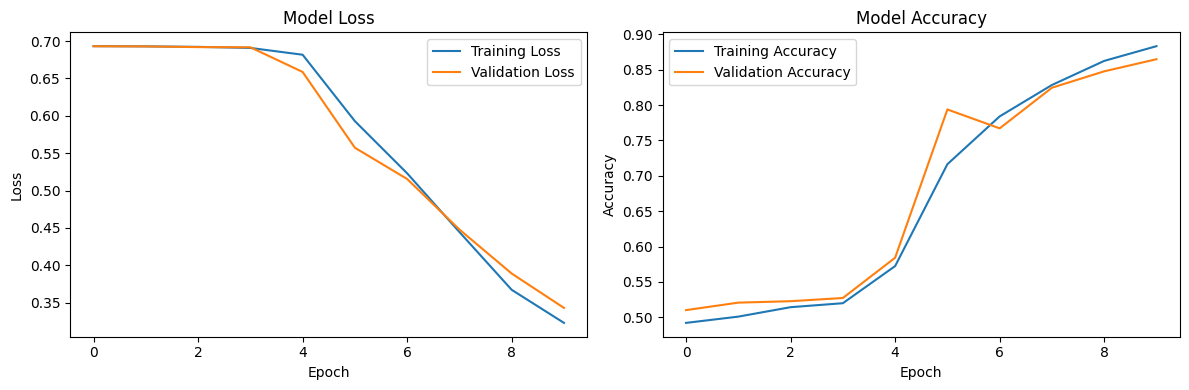


Baseline Model Final Results on Test Set:
Test Accuracy: 0.8135
Test Loss: 0.4517


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate baseline model
baseline_test_loss, baseline_test_acc = baseline_model.evaluate(test_ds, verbose=0)
print(f"\nBaseline Model Final Results on Test Set:")
print(f"Test Accuracy: {baseline_test_acc:.4f}")
print(f"Test Loss: {baseline_test_loss:.4f}")

## Implementasi Solusi

In [ ]:
# [TULIS KODE SOLUSI ANDA DI SINI]
# Tugas utama: Implementasikan pre-trained word embedding (misal: GloVe, Word2Vec).
# Tugas opsional: Coba arsitektur lain seperti Bi-LSTM atau GRU.

# model_solusi = ...

In [ ]:
# [JIKA PERLU, TAMBAHKAN SEL KODE LAGI DI SINI]

# Melatih model solusi Anda
# history_solusi = model_solusi.fit(...)

## Perbandingan dan Analisis Akhir

In [ ]:
# [TULIS KODE UNTUK EVALUASI DAN VISUALISASI MODEL SOLUSI ANDA DI SINI]

# Contoh:
# loss_solusi, accuracy_solusi = model_solusi.evaluate(test_vec_dataset)
# print(f"Akurasi Model Solusi: {accuracy_solusi*100:.2f}%")

# Plot learning curves untuk perbandingan
# plt.plot(...)

## Perbandingan dan Analisis Akhir

**Pendekatan Solusi:**
[Jelaskan pendekatan solusi Anda, termasuk implementasi `pre-trained embedding` dan modifikasi arsitektur (jika ada).]

**Perbandingan Performa:**
- **Akurasi Model Baseline:** [Isi dengan akurasi baseline pada data test, misal: 81.3%]
- **Akurasi Model Solusi:** `[Tulis akurasi solusi]`

**Analisis Singkat:**
[Jelaskan bagaimana performa `pre-trained embedding` pada kasus ini dan berikan analisis perbandingan hasilnya dengan model baseline.]